# ISC image analysis

# import functions

In [ ]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, glob, datetime, gsw, cmocean
from scipy.stats import linregress
from timeinfo import day_night

# import data

In [7]:
file_path = os.path.expanduser('/Users/dong/Desktop/Git/OCEANpy/data')
plot_path = os.path.expanduser("/Users/dong/Desktop/Git/OCEANpy/plots")
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_stb = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()] # select based on the cruise

# create station maps

In [ ]:
cruise_list = ['PS107']
isc_station_list = ['PS107_10_3', 'PS107_12_2', 'PS107_14_7', 'PS107_16_2', 'PS107_18_2', 'PS107_18_7']
isc_sel_stb = isc_stb.loc[isc_stb['cruise_station_haul'].str.contains('|'.join(isc_station_list))] # select by station
isc_sel_dict = {}
for i in cruise_list:
    i_df = isc_sel_stb[isc_sel_stb['cruise_station_haul'].str.contains(i)]
    isc_sel_dict[i] = (tuple(pd.to_numeric(i_df['lat'])) , tuple(pd.to_numeric(i_df['lon'])))
print(isc_sel_dict)
topo = bathy_data (77, 83, -5, 10) # -30, 30, 75, 85
label_color = ['red']
axes, m = station_map(isc_sel_dict, topo, 78.8, 79.2, 1, 4, label_color)
axes.annotate('10', xy=(m(2.52, 78.9769)), fontsize=15)
axes.annotate('12', xy=(m(2.71, 78.9446)), fontsize=15)
axes.annotate('14', xy=(m(2.89, 78.928)), fontsize=15)
axes.annotate('16', xy=(m(2.28, 79.00)), fontsize=15)
axes.annotate('18_2', xy=(m(2.78, 78.985)), fontsize=15)
axes.annotate('18_7', xy=(m(3.25, 79.146)), fontsize=15)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_stationmap_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

# contour transection CTD data

In [ ]:
station_list = ['PS107_10-4', 'PS107_12-3', 'PS107_14-1', 'PS107_16-3']
#station_list = ['PS107_02', 'PS107_06', 'PS107_10', 'PS107_12', 'PS107_14', 'PS107_16', 'PS107_18', 'PS107_20', 'PS107_22', 'PS107_24',
#               'PS107_26', 'PS107_28', 'PS107_29', 'PS107_33', 'PS107_35', 'PS107_42', 'PS107_43', 'PS107_44', 'PS107_45', 'PS107_46',
#               'PS107_47', 'PS107_48', ''PS107_18-3'']
topo = bathy_data (77, 83, -5, 10) # -30, 30, 75, 85
cols_to_use = ['Latitude', 'Longitude', 'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Fluorometer [arbitrary units]', 'Attenuation [arbitrary units]']
ctd_df_filter = ctd_df.loc[ctd_df['Event'].str.contains('|'.join(station_list))] # select by station
ctd_df_filter = ctd_df_filter[cols_to_use] # select only necessary columns
#ctd_df_filter = ctd_df_filter.loc[(pd.to_numeric(ctd_df_filter['Latitude']) >=77) & (pd.to_numeric(ctd_df_filter['Latitude']) <=81)] # select by lat and lon
ctd_df_filter = ctd_df_filter.loc[(pd.to_numeric(ctd_df_filter['Depth water [m]']) <=1000)]
#ctd_df_filter = ctd_df_filter.dropna() # drop rows having empty value (empty values will affect contouring method)

#ctd_df_filter['d_n'] = ctd_df_filter.apply(lambda row: day_night(float(row['Latitude']), float(row['Longitude']), datetime.strptime(row['Date/Time'], '%Y-%m-%dT%H:%M')), axis=1 )
#ctd_df_filter = ctd_df_filter.loc[ctd_df_filter['d_n'] == 'day']
print(list(ctd_df_filter))

depth = [i*(-1) for i in list(pd.to_numeric(ctd_df_filter['Depth water [m]']).values)]
lat = list(pd.to_numeric(ctd_df_filter['Latitude']).values)
lon = list(pd.to_numeric(ctd_df_filter['Longitude']).values)

'''
temp = list(pd.to_numeric(ctd_df_filter['Temp [°C]']).values)
ctd_array = np.array((lat, lon, temp, depth)).transpose() # create array
ax1 = contour_ver(topo, 'lat', 79, (2.2, 2.9), ctd_array, 'Temp [dC]')
ax1.scatter(lon, depth, color='black', s=0.09)
ax1.set_title('Temperature')
ax1.set_ylim(-500, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_CTD_temperature_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

sal = list(pd.to_numeric(ctd_df_filter['Sal']).values)
ctd_array = np.array((lat, lon, sal, depth)).transpose() # create array
ax2 = contour_ver(topo, 'lat', 79, (2.2, 2.9), ctd_array, 'Salinity [PSU]')
ax2.scatter(lon, depth, color='black', s=0.09)
ax2.set_title('Salinity')
ax2.set_ylim(-500, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_CTD_salinity_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

flo = list(pd.to_numeric(ctd_df_filter['Fluorometer [arbitrary units]']).values)
ctd_array = np.array((lat, lon, flo, depth)).transpose() # create array
ax3 = contour_ver(topo, 'lat', 79, (2.2, 2.9), ctd_array, 'Fluorescence')
ax3.scatter(lon, depth, color='black', s=0.09)
ax3.set_title('Fluorescence')
ax3.set_ylim(-500, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_CTD_fluo_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()


o2 = list(pd.to_numeric(ctd_df_filter['O2 [µmol/l]']).values)
ctd_array = np.array((lat, lon, o2, depth)).transpose() # create array
ax4 = contour_ver(topo, 'lat', 79, (2.2, 2.9), ctd_array, 'O2 [µmol/l]')
ax4.scatter(lon, depth, color='black', s=0.09)
ax4.set_title('Oxygen')
ax4.set_ylim(-500, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_CTD_Oxygen_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()


'''
print(ctd_df_filter)

density = list(pd.to_numeric(ctd_df_filter['Press [dbar]']).values)
ctd_array = np.array((lat, lon, density, depth)).transpose() # create array
ax5 = contour_ver(topo, 'lat', 79, (2.2, 2.9), ctd_array, 'Press [dbar]')
ax5.scatter(lon, depth, color='black', s=0.09)
ax5.set_title('Density')
ax5.set_ylim(-500, 0)


#os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
#fig_name = str('Front_CTD_Oxygen_PS107.pdf')
#plt.savefig(fig_name, facecolor='w')
#plt.close()

plt.show()
plt.close()

# contour for particle and zooplankton

In [ ]:
isc_all_df = pd.DataFrame(columns=['cruise_station_cast','lat', 'lon', 'depth', 'temp', 'sal','turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
for index, value in isc_each_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, cast, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), str(value['cruise_station_haul'].split('_')[2]),int(float(value['profile_number']))
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            lat, lon = value['lat'], value['lon']
            particle_range = [150, 500, 1000, 100000] # micro meter
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range, 'processed')
            df = pd.DataFrame(columns=['lat', 'lon', 'depth', 'temp', 'sal', 'turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
            df['depth'], df['sal'], df['temp']  = isc_ctd_df['Depths (m)'], isc_ctd_df['Salinity (PSU)'], isc_ctd_df['Temperature (dC)']
            df['turb'], df['fluo'] = isc_ctd_df['Turbidity (NTU)'], isc_ctd_df['Fluorescence (mg/m3)']
            df['ctd_total_vol'], df['ctd_total_abd'] = isc_ctd_df['Total Aggregate Volume (ppm)'], isc_ctd_df['Aggregate abundance (#/l)']
            df['med_ESD'], df['avg_ESD'] = isc_ctd_df['Median ESD (µm)'], isc_ctd_df['Average ESD (µm)']
            df['vol_150-500'], df['vol_500-1000'], df['vol_total'] = vol_spec_df['150-500'], vol_spec_df['500-1000'], vol_spec_df['total']
            df['abd_150-500'], df['abd_500-1000'], df['abd_total'] = aggr_con_df['150-500'], aggr_con_df['500-1000'], aggr_con_df['total']
            df['lat'], df['lon'] = lat, lon
            df['cruise_station_cast'] = str(cruise) +'_'+ str(station) +'_'+ str(cast)
            
            isc_all_df = isc_all_df.append(df, ignore_index=True)

isc_all_df = isc_all_df.dropna()
isc_all_df.loc[:, isc_all_df.columns != 'cruise_station_cast'] = isc_all_df.loc[:, isc_all_df.columns != 'cruise_station_cast'].applymap(lambda x:pd.to_numeric(x))


In [ ]:
isc_station_list = ['PS107_10_3', 'PS107_12_2', 'PS107_14_7', 'PS107_16_2']
isc_sel_df = isc_all_df.loc[isc_all_df['cruise_station_cast'].str.contains('|'.join(isc_station_list))] # select by station
print(list(isc_sel_df))

lat, lon, depth = isc_sel_df['lat'], isc_sel_df['lon'], isc_sel_df['depth'].apply(lambda x:x*(-1))
'''

abd = isc_sel_df['abd_total']
isc_array = np.array((lat, lon, abd, depth)).transpose() # create array
ax1 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'concentration [#/L]')
ax1.scatter(lon, depth, color='black', s=0.3)
ax1.set_title('Abundance total')
ax1.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_particle_abudance_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

ESD = isc_sel_df['med_ESD']
isc_array = np.array((lat, lon, ESD, depth)).transpose() # create array
ax3 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'ESD')
ax3.scatter(lon, depth, color='black', s=0.3)
ax3.set_title('Median ESD')
ax3.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_particle_median_ESD_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

plt.show()
plt.close()

vol = isc_sel_df['vol_150-500']
isc_array = np.array((lat, lon, vol, depth)).transpose() # create array
ax2 = contour_ver(topo, 'lat', 79, (-10, 12), isc_array, 'Volume [ppm]')
ax2.set_title('Volume 150-500')

'''

temp = isc_sel_df['temp']
isc_array = np.array((lat, lon, temp, depth)).transpose() # create array
ax8 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'Temperature [dC]')
ax8.scatter(lon, depth, color='black', s=0.3)
ax8.set_title('Temperature_ISC')
ax8.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_isc_ctd_temp_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()


sal = isc_sel_df['sal']
isc_array = np.array((lat, lon, sal, depth)).transpose() # create array
ax9 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'Salinity (PSU)')
ax9.scatter(lon, depth, color='black', s=0.3)
ax9.set_title('Salinity_ISC')
ax9.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_isc_ctd_sal_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()


turb = isc_sel_df['turb']
isc_array = np.array((lat, lon, turb, depth)).transpose() # create array
ax4 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'Turbidity (NTU)')
ax4.scatter(lon, depth, color='black', s=0.3)
ax4.set_title('Turbidity')
ax4.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_isc_ctd_turb_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

fluo = isc_sel_df['fluo']
isc_array = np.array((lat, lon, fluo, depth)).transpose() # create array
ax5 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'Fluorescence (mg/m3)')
ax5.scatter(lon, depth, color='black', s=0.3)
ax5.set_title('Fluorescence')
ax5.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_isc_ctd_fluo_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

ctd_vol = isc_sel_df['ctd_total_vol']
isc_array = np.array((lat, lon, ctd_vol, depth)).transpose() # create array
ax6 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'Total Aggregate Volume (ppm)')
ax6.scatter(lon, depth, color='black', s=0.3)
ax6.set_title('Total Aggregate Volume')
ax6.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_isc_ctd_total_vol_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

ctd_abd = isc_sel_df['ctd_total_abd']
isc_array = np.array((lat, lon, ctd_abd, depth)).transpose() # create array
ax7 = contour_ver(topo, 'lat', 79, (2.2, 2.9), isc_array, 'Aggregate abundance (#/l)')
ax7.scatter(lon, depth, color='black', s=0.3)
ax7.set_title('Aggregate abundance')
ax7.set_ylim(-400, 0)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_isc_ctd_total_abd_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

In [ ]:
loki_station_list = ['PS107_010-5', 'PS107_012-4', 'PS107_014-5', 'PS107_016-4']
loki_sel_df = loki_df.loc[loki_df['station'].str.contains('|'.join(loki_station_list))] # select by station
loki_sel_df = loki_sel_df[loki_sel_df['copepod']==True]
loki_sel_df['copepod'] = loki_sel_df['copepod'].replace(True, 1)

loki_bin_df = pd.DataFrame(columns =['station', 'latitude', 'longitude','loki_depth', 'copepod'])
for st in loki_sel_df['station'].drop_duplicates():
    i_df = loki_sel_df[loki_sel_df['station'] == st]
    depth_bin = range(0, int(max(loki_sel_df['loki_depth']))+10, 10)
    for i in range(0, len(depth_bin)-1):
        bin_df = i_df.loc[(i_df['loki_depth'] > depth_bin[i]) & (i_df['loki_depth'] <= depth_bin[i+1])]
        lat = bin_df['latitude'].iloc[0]
        lon = bin_df['longitude'].iloc[0]
        station = bin_df['station'].iloc[0]
        
        count = np.sum(bin_df['copepod'])
        depth = np.mean(bin_df['loki_depth'])
        
        loki_bin_df = loki_bin_df.append({'station':station, 'latitude':lat, 'longitude':lon,'loki_depth':depth, 'copepod':count}, ignore_index=True)
        
lat, lon, depth = loki_bin_df['latitude'], loki_bin_df['longitude'], loki_bin_df['loki_depth'].apply(lambda x:x*(-1))

copepoda = loki_bin_df['copepod']
loki_array = np.array((lat, lon, copepoda, depth)).transpose() # create array
ax1 = contour_ver(topo, 'lat', 79, (2.2, 2.9), loki_array, 'count [#]')
ax1.scatter(lon, depth, color='black', s=0.3)
ax1.set_title('copepoda')
ax1.set_ylim(-400, 0)


os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('Front_copepod_abundance_PS107.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

plt.show()
plt.close()


# particle plots

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(25, 13))

ax1 = ax[0,0]
ax1.set_title('Abundance VS Temperature')
sc1 = ax1.scatter(isc_all_df['abd_total'],isc_all_df['temp'], s=3, c=isc_all_df['depth'], cmap=cmocean.cm.thermal, alpha=0.7)
ax1.set_xlabel('Concentration [#/L]')
ax1.set_ylabel('Temperature [dC]')
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('depth [m]', rotation=90)

ax2 = ax[0,1]
ax2.set_title('Abundance VS Salinity')
sc2 = ax2.scatter(isc_all_df['abd_total'], isc_all_df['sal'],  s=2, c=isc_all_df['depth'], cmap=cmocean.cm.thermal, alpha=0.7)
ax2.set_ylim(33, 36)
ax2.set_xlabel('Concentration [#/L]')
ax2.set_ylabel('Salinity [PSU]')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('depth [m]', rotation=90)

ax3 = ax[0,2]
ax3.set_title('Abundance VS ESD')
sc3 = ax3.scatter(isc_all_df['abd_total'], isc_all_df['avg_ESD'], s=2, c=isc_all_df['depth'], cmap=cmocean.cm.thermal, alpha=0.7)
#ax3.scatter(isc_all_df['abd_total'], isc_all_df['med_ESD'], s=1, c='blue', alpha=0.7)
ax3.set_xlabel('Concentration [#/L]')
ax3.set_ylabel('ESD')
cbar3 = plt.colorbar(sc3, ax=ax3)
cbar3.set_label('depth [m]', rotation=90)

os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
fig_name = str('particle_abundace_analysis.pdf')
plt.savefig(fig_name, facecolor='w')
plt.close()

'''
plt.title('Temprature VS Volume')
plt.scatter(isc_all_df['temp'],  isc_all_df['vol_150-500']+isc_all_df['vol_500-1000'])
plt.show()
plt.close()

plt.title('Salinity VS Volume')
plt.scatter(isc_all_df['sal'],  isc_all_df['vol_150-500']+isc_all_df['vol_500-1000'])
plt.xlim(33, 36)
plt.show()
plt.close()

plt.title('Abundance VS Volume')
plt.scatter(isc_all_df['abd_150-500']+isc_all_df['abd_500-1000'], isc_all_df['vol_150-500']+isc_all_df['vol_500-1000'])
plt.show()
plt.close()
'''

# particle size spectra VS ESD plot

<ipython-input-10-3224d7e3dd4d>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,10))


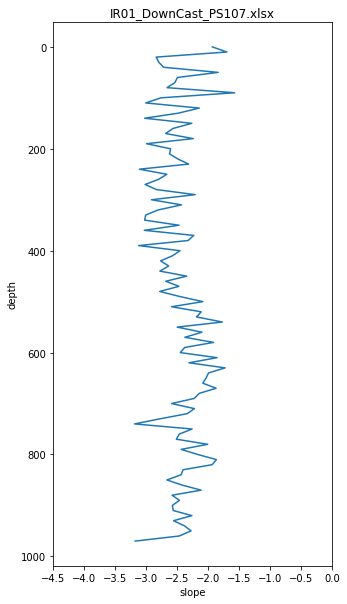

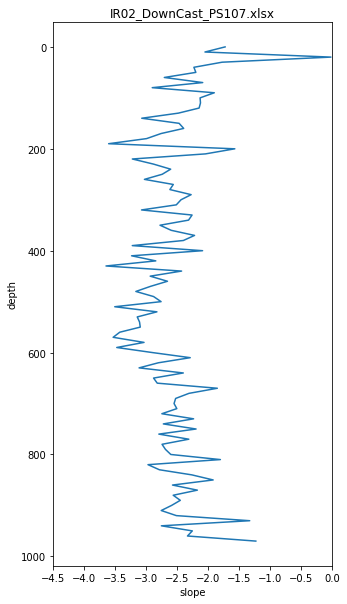

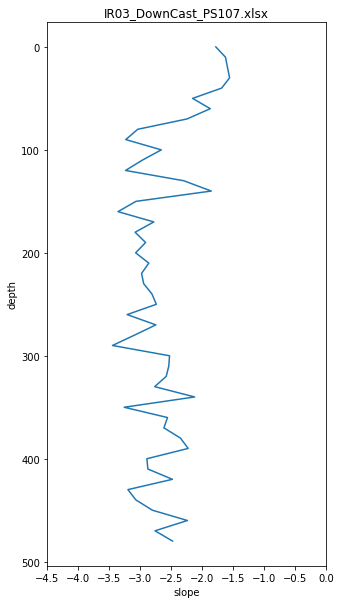

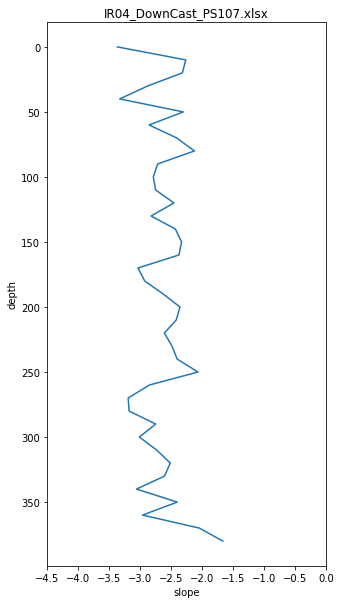

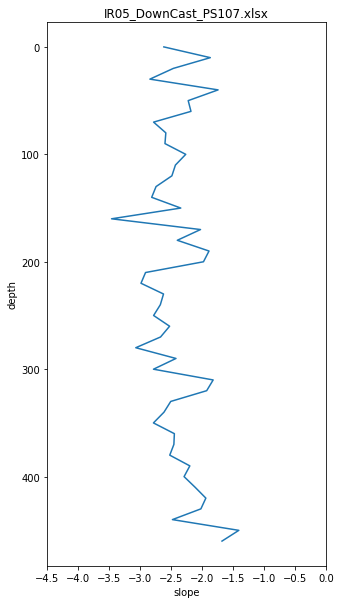

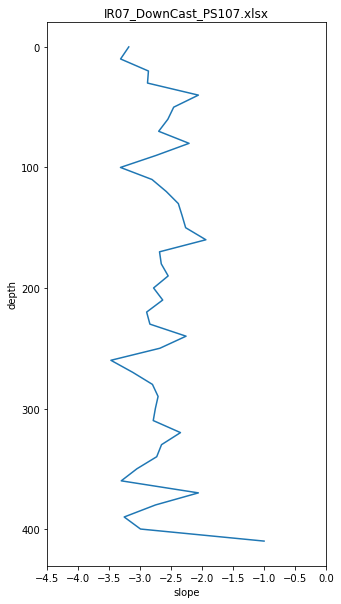

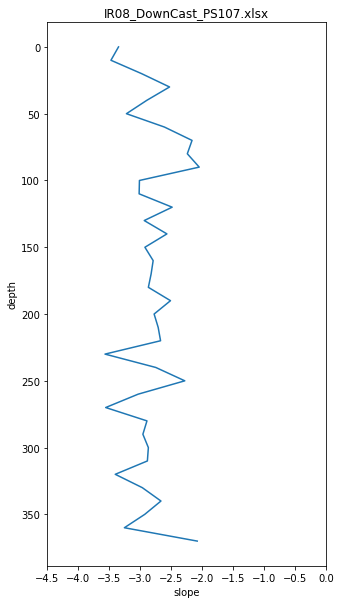

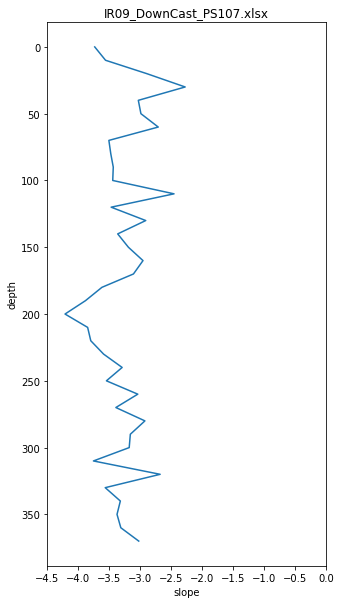

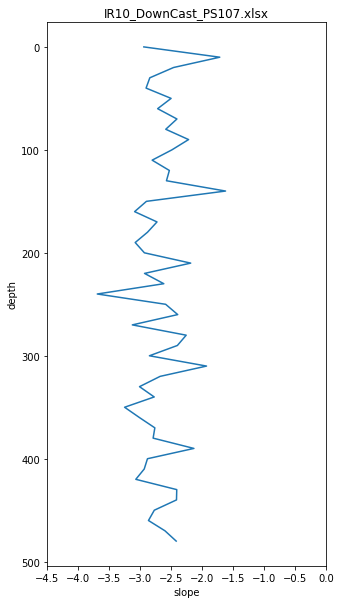

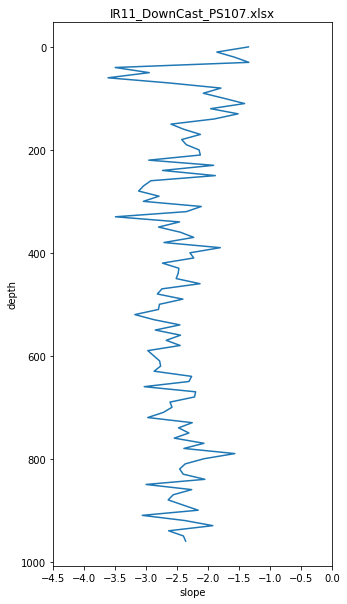

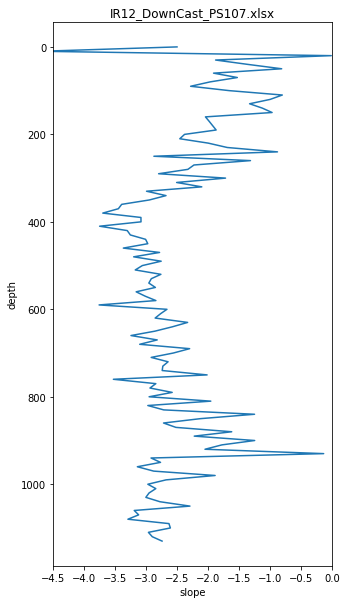

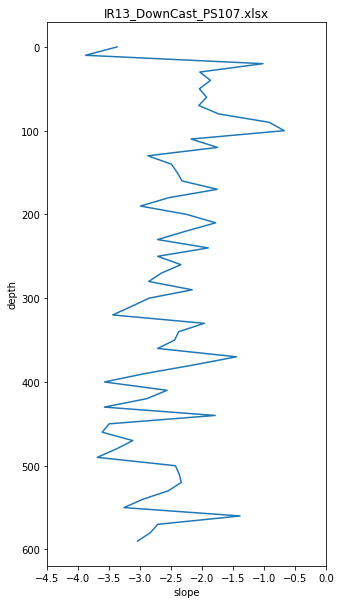

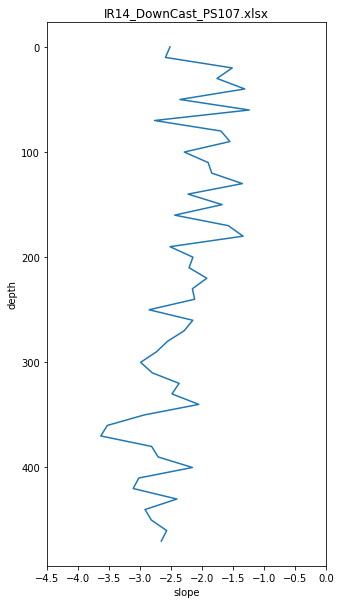

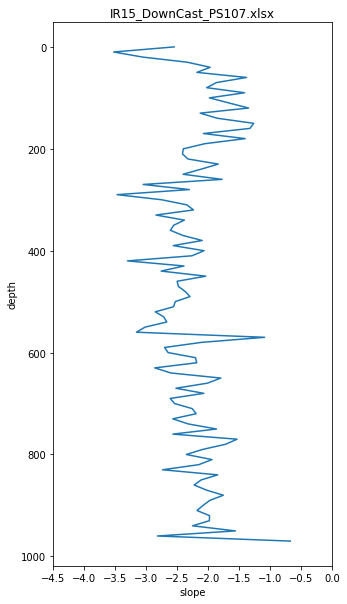

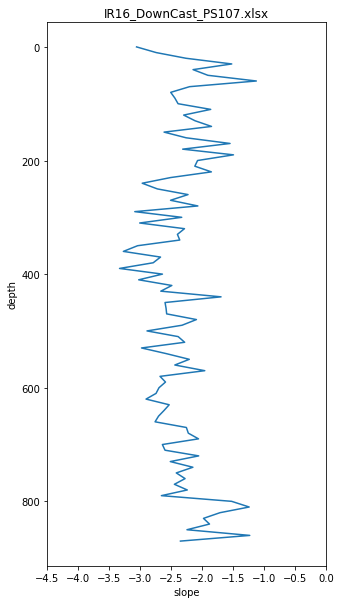

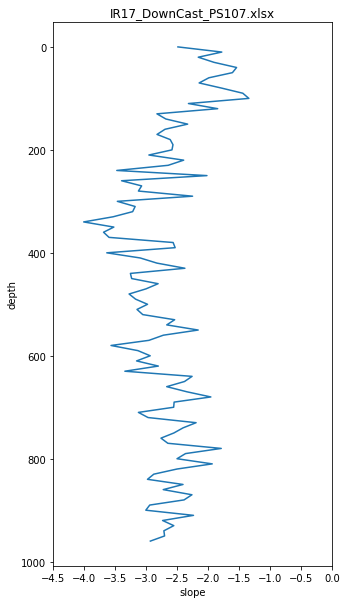

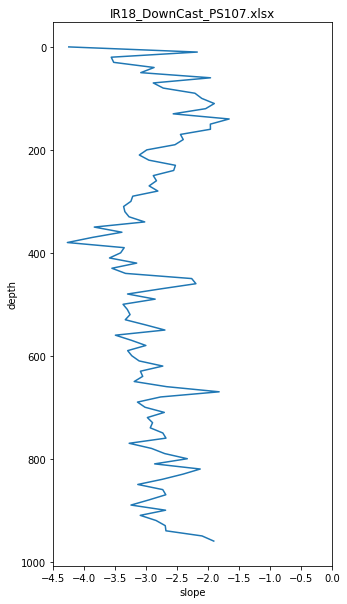

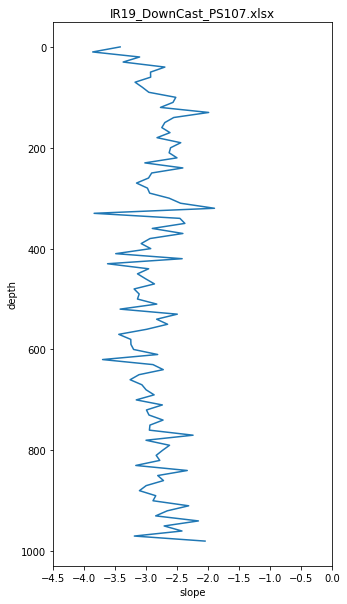

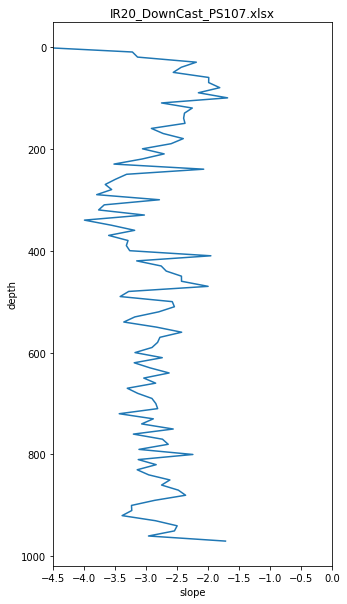

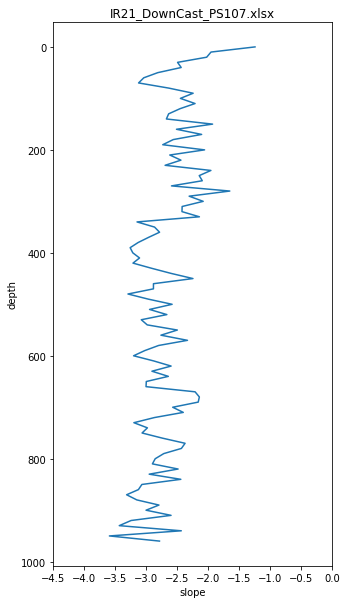

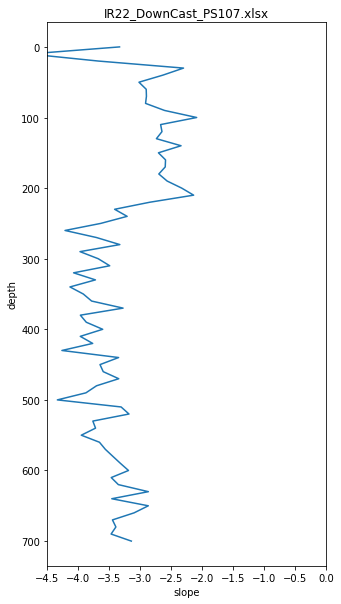

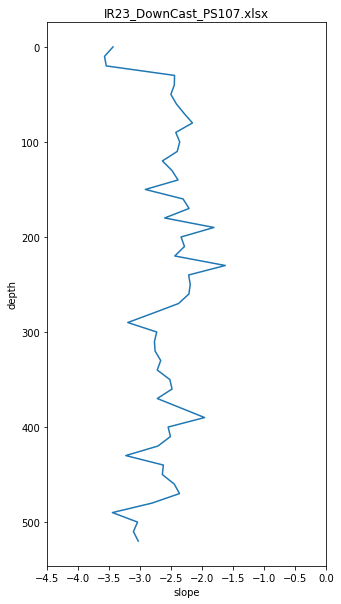

In [10]:
ss_esd_df = pd.DataFrame(columns=['depth', 'slope'])
for index, value in isc_each_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))

    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            ctd_df, vol_spec_df, aggr_con_df, size_spec_df = read_isc(i, 'processed')
            size_spec_cols = list(size_spec_df.columns)[12:26]

            depth_range = range(0, int(max(size_spec_df['Depths (m)']))+10, 10) # use size spectra df for ESD (from columns) and size spectra (values)
            slopes = []
            for d in range(0, len(depth_range)-1):
                i_size_spec_df = size_spec_df.loc[(depth_range[d] <= size_spec_df["Depths (m)"]) & (size_spec_df["Depths (m)"] < depth_range[d+1])]
                mean_size_spec_list = [ np.nan if i == 0 else np.log(i) for i in list(i_size_spec_df.loc[:, size_spec_cols].mean()) ]
                ESD = [ np.nan if i == 0 else np.log(i) for i in size_spec_cols ]
                mask = ~np.isnan(mean_size_spec_list) & ~np.isnan(ESD)
                
                # in case for print the plot
                #plt.scatter(ESD, mean_size_spec_list)
                #plt.xlabel('Log(ESD)')
                #plt.ylabel('Log(Size Spectra)')
                #plt.show()
                #plt.close()

                slope, intercept, r_value, p_value, std_err = linregress(np.array(ESD)[mask], np.array(mean_size_spec_list)[mask])
                slopes.append(slope)

            plt.figure(figsize=(5,10))
            plt.plot(slopes, depth_range[0:len(slopes)])
            plt.gca().invert_yaxis()
            plt.xlabel('slope')
            plt.ylabel('depth')
            plt.xlim(-4.5, 0)
            plt.title(isc_excel)

            fig_name = os.path.join(plot_path, isc_excel.replace(".xlsx", "")+".pdf" )
            plt.savefig(fig_name, facecolor='w', dpi=300)

# all plot

In [ ]:
for index, value in isc_each_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), int(float(value['profile_number']))
    
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            particle_range = [150, 500, 1000, 100000] # micro meter
            
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range, 'raw')
            vol, abd, isc_ctd, ctd_dict = isc_summary(isc_ctd_df, vol_spec_df, aggr_con_df, particle_range)
            loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station

            if loki_station_df.empty:
                continue
            else:
                print(value['cruise_station_haul'])
                ctd_station_df = ctd_df[ctd_df['Event'].str.contains(cruise+'_'+str(station))] # select corresponding ctd station
                Sal = tuple(pd.to_numeric(ctd_station_df['Sal']))
                Depth = tuple(pd.to_numeric(ctd_station_df['Depth water [m]']))
                Temp = tuple(pd.to_numeric(ctd_station_df['Temp [°C]']))
                Fluo = tuple(pd.to_numeric(ctd_station_df['Fluorometer [arbitrary units]']))
                
                copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
                copepoda_depth = copepoda_df['loki_depth'].to_list()
                
                oncaeidae_df = loki_station_df[loki_station_df['family']=='Oncaeidae'] # df only for copepoda
                oncaeidae_depth = oncaeidae_df['loki_depth'].to_list()
                
                calanidae_df = loki_station_df[loki_station_df['family']=='Calanidae'] # df only for copepoda
                calanidae_depth = calanidae_df['loki_depth'].to_list()
                
                metridinidae_df = loki_station_df[loki_station_df['family']=='Metridinidae'] # df only for copepoda
                metridinidae_depth = metridinidae_df['loki_depth'].to_list()
                
                loki_family_dict = dict(loki_station_df['family'].value_counts())
                
                
                fig = plt.figure(constrained_layout=True, figsize =(20, 18))
                gs = fig.add_gridspec(3, 4)
                
                #fig, axs = plt.subplots(6,3, figsize = (10, 25))
                #axs = axs.ravel()

                # 1st plot for temperature and salanity and Fluorescence / data from CTD
                ### CTD ###
                ax1 = fig.add_subplot(gs[0,0])
                ax1.plot(Sal, Depth, color ='blue', linewidth= 1)
                ax1.set_ylabel(ctd_dict['depth'], color ='black', fontsize=15)
                ax1.set_xlabel(ctd_dict['sal'], color = 'blue', fontsize=15)
                ax1.set_xlim(30, 36)
                ax1.set_ylim(0,500)
                ax1.annotate('CTD', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

                sec_axs = ax1.twiny()
                sec_axs.plot(Temp, Depth, color='red', linewidth= 1)
                sec_axs.set_xlabel(ctd_dict['temp'], color = 'red', fontsize=15)
                sec_axs.set_xlim(-3, 9)
                
                thr_axs = ax1.twiny()
                thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
                thr_axs.xaxis.set_ticks_position('bottom')
                thr_axs.xaxis.set_label_position('bottom')
                thr_axs.plot(Fluo, Depth, color='green', linewidth= 1)
                thr_axs.set_xlabel(ctd_dict['fluo'], color = 'green', fontsize=15)
                thr_axs.set_xlim(-0.5, 6)
                thr_axs.invert_yaxis()
                
                # 2nd plot TS diagram                
                mint= -2 # contour for density
                maxt= 6
                mins= 30
                maxs= 36
                
                tempL=np.linspace(mint-1,maxt+1,156)
                salL=np.linspace(mins-1,maxs+1,156)
                
                Tg, Sg = np.meshgrid(tempL,salL)
                sigma_theta = gsw.sigma0(Sg, Tg)
                cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),156) # density contour data generated
                
                ax2 = fig.add_subplot(gs[0,1])
                sc = ax2.scatter(Sal, Temp, c=Depth, cmap = 'jet_r', s=10)
                cs = ax2.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
                cl=plt.clabel(cs,fontsize=13,inline=True,fmt='%.1f')
                
                ax2.set_xlim(30, 36)
                ax2.set_ylim(-2, 6)
                ax2.set_title('TS diagram', fontsize=15)
                ax2.set_xlabel('Salinity [PSU]', fontsize=15)
                ax2.set_ylabel('Temperature [dC]', fontsize=15)

                cbar = plt.colorbar(sc)
                cbar.ax.set_ylabel('Depth [m]', rotation=270, labelpad=15, fontsize=15)

                # 3rd plot copepoda
                ax3 = fig.add_subplot(gs[1,:3])
                ax3.bar(loki_family_dict.keys(), loki_family_dict.values(), color='black') # family abundance check
                ax3.tick_params(rotation=90)
                
                # 4th plot all copepoda profile with particle abd and vol
                ax4 = fig.add_subplot(gs[1,3])
                ax4.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax4.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax4.set_ylim(0,500)
                ax4.set_xlim(0,60)
                

                sec_axs = ax4.twiny()
                sec_axs.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('copepoda [count]', color = 'black', fontsize=15)
                

                thr_axs = ax4.twiny()
                thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
                thr_axs.xaxis.set_ticks_position('bottom')
                thr_axs.xaxis.set_label_position('bottom')
                thr_axs.plot(vol['vol_tol'], isc_ctd['depth'], color='blue', linewidth= 1)
                thr_axs.set_xlabel('total particle vol [ppm]', color = 'blue', fontsize=15)
                thr_axs.set_xlim(0,10)
                thr_axs.invert_yaxis()
                
                
                # each sp. level
                ax5 = fig.add_subplot(gs[2,0])
                ax5.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax5.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax5.set_ylim(0,500)

                sec_axs = ax5.twiny()
                sec_axs.hist(oncaeidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('oncaeidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                ax6 = fig.add_subplot(gs[2,1])
                ax6.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax6.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax6.set_ylim(0,500)

                sec_axs = ax6.twiny()
                sec_axs.hist(calanidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('calanidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()
                
                
                ax7 = fig.add_subplot(gs[2,2])
                ax7.plot(abd['abd_tol'], isc_ctd['depth'], color='red', linewidth= 1)
                ax7.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
                ax7.set_ylim(0,500)

                sec_axs = ax7.twiny()
                sec_axs.hist(metridinidae_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.1, color='black')
                sec_axs.set_xlim(0,300)
                sec_axs.set_xlabel('metridinidae [count]', color = 'black', fontsize=15)
                sec_axs.invert_yaxis()

                os.chdir(os.path.expanduser('~/Git/OCEANpy/plots'))
                fig_name = str('ISC_LOKI_'+value['cruise_station_haul']+'.pdf')
                plt.savefig(fig_name, facecolor='w')
                #plt.show()
                #plt.close()